In [2]:
# Question 1
import numpy as np
from scipy.stats import norm
import scipy.stats as stats

# set parameters
S1_0, S2_0, K, r, T = 1, 1, 1.5, 0.03, 1
mu = np.array([r, r])
sigma = np.array([[1, 0], [0, 1]])
n_simulations = 20000

# calculate Y1, Y2, Y3
def spread_payoff(r, T, S1_T, S2_T, K):
    return np.exp(-r * T) * np.maximum(S1_T - S2_T - K, 0)

def basket_payoff(r, T, S1_T, S2_T, K):
    return np.exp(-r * T) * np.maximum(S1_T + S2_T - K, 0)

def outperformance_payoff(r, T, S1_T, S2_T, K):
    return np.exp(-r * T) * np.maximum(np.maximum(S1_T, S2_T) - K, 0)

# simulation process
def monte_carlo_simulation(c):
    # set the covariance matrix
    sigma[0, 1] = sigma[1, 0] = c

    # Simulate the asset paths
    Z = norm.rvs(size=(n_simulations, 2))

    # cholesky decomposition
    L = np.linalg.cholesky(sigma)
    asset_paths = np.exp((mu - 0.5 * np.diag(sigma)) * T + np.sqrt(T) * np.dot(Z, L.T))
    S1_T = S1_0 * asset_paths[:, 0]
    S2_T = S2_0 * asset_paths[:, 1]

    # Calculate the payoffs
    Y1 = spread_payoff(r, T, S1_T, S2_T, K)
    Y2 = basket_payoff(r, T, S1_T, S2_T, K)
    Y3 = outperformance_payoff(r, T, S1_T, S2_T, K)

    # Calculate 95% confidence intervals
    Y1_CI = stats.t.interval(0.95, len(Y1)-1, loc=np.mean(Y1), scale=stats.sem(Y1))
    Y2_CI = stats.t.interval(0.95, len(Y2)-1, loc=np.mean(Y2), scale=stats.sem(Y2))
    Y3_CI = stats.t.interval(0.95, len(Y3)-1, loc=np.mean(Y3), scale=stats.sem(Y3))

    print("When c = ", c)
    print("The 95% Confidence Interval of E[Y1] = ", Y1_CI)
    print("The 95% Confidence Interval of E[Y2] = ", Y2_CI)
    print("The 95% Confidence Interval of E[Y3] = ", Y3_CI)

c_list = [0, 0.5, -0.5]

for c in c_list:
    monte_carlo_simulation(c)

When c =  0
The 95% Confidence Interval of E[Y1] =  (0.15906371402686506, 0.18367289815149399)
The 95% Confidence Interval of E[Y2] =  (0.7914463522696675, 0.8366681046069202)
The 95% Confidence Interval of E[Y3] =  (0.4954349231684268, 0.5336550445640464)
When c =  0.5
The 95% Confidence Interval of E[Y1] =  (0.1594791216018361, 0.18360488281694157)
The 95% Confidence Interval of E[Y2] =  (0.8063871162279503, 0.8521607002214291)
The 95% Confidence Interval of E[Y3] =  (0.5021817622141712, 0.5398600285136635)
When c =  -0.5
The 95% Confidence Interval of E[Y1] =  (0.16137742749726156, 0.18566711358297885)
The 95% Confidence Interval of E[Y2] =  (0.800607957927043, 0.8462731334015888)
The 95% Confidence Interval of E[Y3] =  (0.5007240041546568, 0.5391840466667432)


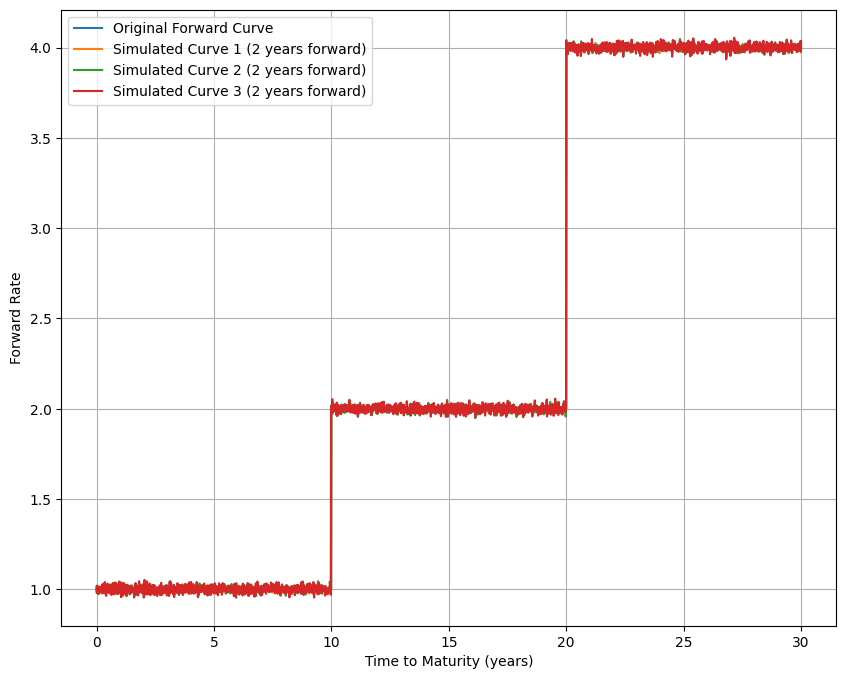

In [3]:
# Question 2
import numpy as np
import matplotlib.pyplot as plt

# set parameters
T_max = 30
n_points = 3000
delta = 0.01
sigma = 0.1
n_years_forward = 2
n_steps_forward = int(n_years_forward / delta)

# set the orginal curve
f = np.zeros(n_points)
f[:1000] = 1
f[1000:2000] = 2
f[2000:] = 4

# simulate the forward rate curve
def simulate_forward_curve(f, sigma, n_steps_forward, delta):
    n_points = len(f)
    curves = [f]
    for _ in range(n_steps_forward):
        new_curve = np.zeros(n_points - 2)
        for i in range(1, n_points - 1):
            # HJM euler discretization step
            new_curve[i - 1] = curves[-1][i] + sigma * sigma * delta + sigma * np.sqrt(delta) * np.random.normal()
        curves.append(new_curve)
        n_points -= 1
    return curves

simulated_curves = simulate_forward_curve(f, sigma, n_steps_forward, delta)

# plot the curve
plt.figure(figsize=(10, 8))
t = np.linspace(0, T_max, n_points)
plt.plot(t, f, label="Original Forward Curve")
for i, curve in enumerate(simulated_curves[1:4], 1):
    t = np.linspace(0, T_max, len(curve))
    plt.plot(t, curve, label=f"Simulated Curve {i} (2 years forward)")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Forward Rate")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Question 3

# (a)
# set parameters
K = 80
b = 100
T = 1
S0 = 75
r = 0.045
sigma = 0.3
n_simulations = 5000
n_steps = 2 ** 10
dt = 2 ** (-10)

# simulate the asset price
def option_price_simulate():
    S = np.zeros(n_steps + 1)
    S[0] = S0
    for t in range(1, len(S)):
        Z = np.random.normal(0, 1)
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        if S[t] >= b:
            return 0, S[-1]

    return np.exp(-r * T) * max(S[-1] - K, 0), S[-1]

# repeat for 5000 times
payoffs = np.zeros(n_simulations)
for i in range(n_simulations):
  payoff, asset_price = option_price_simulate()
  payoffs[i] = payoff

# calculate confidence interval
option_estimated_price = np.mean(payoffs)
std_error = np.std(payoffs) / np.sqrt(n_simulations)
CI = stats.norm.interval(0.95, loc = option_estimated_price, scale = std_error)

print("The 95% Confidence Interval = ", CI)

The 95% Confidence Interval =  (0.7224618811132134, 0.8695490158468716)


The estimate is biased because of the discretization of simulation. In a continuous model, the barrier could be breached at any time, but with discrete steps, there is a possibility that we miss the exact moment when the price hits or exceeds the barrier. This can lead to an overestimation of the option price since we might miss some paths where the option should become worthless but does not within the discrete steps used in the simulation. ​

In [17]:
# (b)
from scipy.stats import norm

# reset simulation process func
def simulate_asset_path_and_terminal_price():
    S = np.zeros(n_steps + 1)
    S[0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal()
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        if S[t] >= b:
            return 0, S[t]
    payoff = np.exp(-r * T) * max(S[N] - K, 0)
    return payoff, S[N]

results = np.array([simulate_asset_path_and_terminal_price() for _ in range(n_simulations)])
payoffs = results[:, 0]
control_variate_values = results[:, 1]

# calculate covariance and variance
covariance = np.cov(payoffs, control_variate_values)[0, 1]
control_variate_variance = np.var(control_variate_values)

# calculate beta
beta = covariance / control_variate_variance
adjusted_payoffs = payoffs - beta * (control_variate_values - np.exp(r * T) * S0)

#estimate point value and confidence interval
option_price_estimate_cv = np.mean(adjusted_payoffs)
std_error_cv = np.std(adjusted_payoffs) / np.sqrt(n_simulations)
CI = (option_price_estimate_cv - 1.96 * std_error_cv,
      option_price_estimate_cv + 1.96 * std_error_cv)

# calculate variance reduction
variance_reduction = 100 * (1 - np.var(adjusted_payoffs) / np.var(payoffs))

print("The Point Estimate = ", option_price_estimate_cv)
print("The 95% Confidence Interval = ", CI)
print("The Variacne Reduction = ", variance_reduction)

The Point Estimate =  0.8482327888296124
The 95% Confidence Interval =  (0.7747583960255112, 0.9217071816337136)
The Variacne Reduction =  3.9368787044107623


In [13]:
# (c)
indicator_probability = 0.1215

# reset simulation process func (add indicator)
def calculate_payoff_and_indicator():
    S = S0
    max_S = S0
    for _ in range(n_steps):
        Z = np.random.normal()
        S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        max_S = max(max_S, S)
        if S >= b:
            return 0, 0
    payoff = max(S - K, 0) * np.exp(-r * T)
    indicator = 1 if (max_S < b and S > K) else 0
    return payoff, indicator

payoffs_and_indicators = np.array([calculate_payoff_and_indicator() for _ in range(n_simulations)])
payoffs = payoffs_and_indicators[:, 0]
indicators = payoffs_and_indicators[:, 1]

# adjust payoff
beta_indicator = np.cov(payoffs, indicators)[0, 1] / np.var(indicators)
payoffs_adjusted_indicator = payoffs + beta_indicator * (indicator_probability - indicators)
option_price_estimate_cv_indicator = np.mean(payoffs_adjusted_indicator)
std_error_cv_indicator = np.std(payoffs_adjusted_indicator) / np.sqrt(n_simulations)
CI = ( option_price_estimate_cv_indicator - 1.96 * std_error_cv_indicator,
       option_price_estimate_cv_indicator + 1.96 * std_error_cv_indicator)

# calculate variance reduction
variance_reduction_indicator = 100 * (1 - np.var(payoffs_adjusted_indicator) / np.var(payoffs))

print("The Point Estimate = ", option_price_estimate_cv_indicator)
print("The 95% Confidence Interval = ", CI)
print("The Variacne Reduction = ", variance_reduction_indicator)

The Point Estimate =  0.8187117296904461
The 95% Confidence Interval =  (0.7739829392645622, 0.8634405201163301)
The Variacne Reduction =  65.81783306369368
